In [145]:
cd ..

/Users/jwen/Stanford/projects/smoke_segmentation


In [146]:
cd src

/Users/jwen/Stanford/projects/smoke_segmentation/src


In [147]:
#from metrics import lovasz as lov_loss
import torch
import time
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from utils.data_set import WildfireSmokeDataset
from utils import data_vis
from utils import augmentation as aug
from matplotlib import pyplot as plt

%matplotlib inline

In [148]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading in data

In [70]:
train_dataset = WildfireSmokeDataset('../data/crops_unfiltered/file_index.csv', 
                     root_dir='crops_unfiltered',train_val_test='train', 
                                     bands=['true_color','C07','C11','merra2'], 
                                     #bands=['true_color','C07','C11'], 
                                     #bands=['true_color', 'C07'],
                                     #bands=['true_color'], 
                                     #transform=None)
                                     transform=transforms.Compose([aug.ToTensorTarget()]))

In [71]:
train_loader = DataLoader(train_dataset, batch_size=3, num_workers=0, shuffle=True)

In [72]:
blah = next(iter(train_loader))
#blah = next(iter(train_dataset))

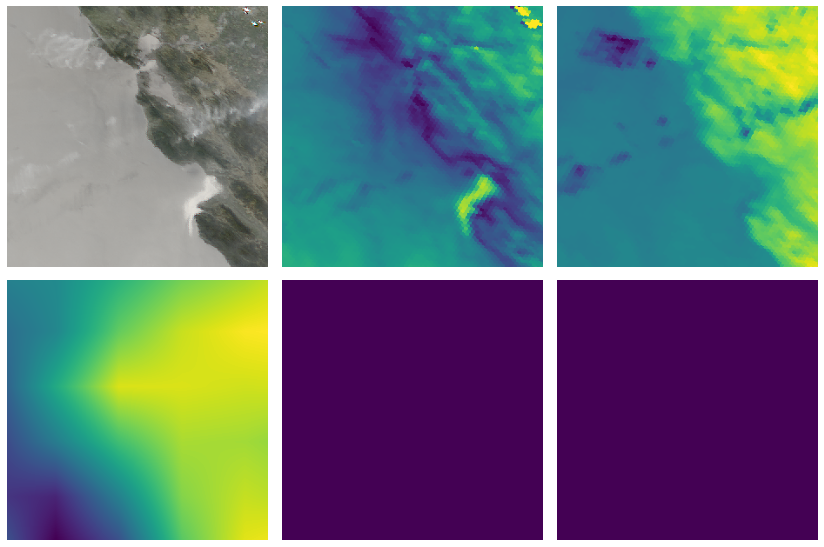

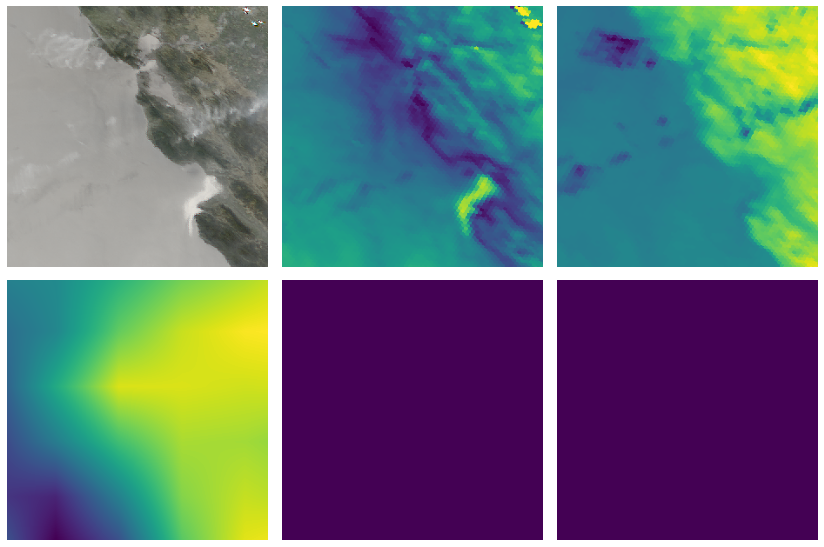

In [134]:
data_vis.show_tensorboard_image(blah['sat_img'], blah['map_img'], blah['map_img'])

In [52]:
zing = io.imread('../data/crops/train/true_color_G16_doy321_s201811172357_e201811172359_7.png')
blah = io.imread('../data/crops/train/C07_G16_doy321_s201811172357_e201811172359_7.png')

In [57]:
np.dstack([zing, blah[:,:,0], blah[:,:,0]]).shape

(300, 300, 5)

In [267]:
blah = train_dataset[0]['map_img']

In [103]:
ax.shape

(2, 3)

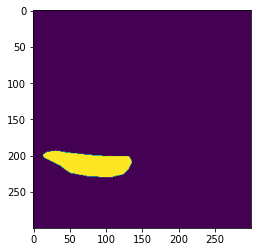

In [278]:
plt.imshow(blah[2,:,:].cpu().numpy())

## Predict using trained model
* Load model, predict on full size images

In [56]:
import glob
import os
import pandas as pd

from models import unet
from utils import helpers as h

## gather image filenames for true_color (which each has corresponding channel/ masks)
imgs = glob.glob(f'../data/img/test_img/true_color*')

In [435]:
file_str = os.path.basename(imgs[0])
print(f"fname_params: {h.get_true_color_filename_split_dict(file_str)}")
print(f"file_str: {file_str}")
print(f"true_color_fn: {file_str.split('/')[-1]}")
print(f"start_end_slug: {true_color_fn.split('_')[4] +'_'+ true_color_fn.split('_')[5].split('.')[0]}")

print(f"true_color_{'_'.join(file_str.split('/')[-1].split('_')[2:])}")

fname_params: {'year': '2018', 'month': '09', 'day': '16', 'time': '1602'}
file_str: true_color_G16_doy259_s201809161602_e201809161604.tiff
true_color_fn: true_color_G16_doy259_s201809161602_e201809161604.tiff
start_end_slug: s201808051730_e201808051741
true_color_G16_doy259_s201809161602_e201809161604.tiff


In [188]:
file_dict = {'true_color':[], 'C07': [], 'C11':[], 'mask': [], 'merra2': [], 'train_val_test': []}
for file_str in imgs:
    
    img_slug = '_'.join(os.path.basename(file_str).split('_')[:6])
    
    file_dict['true_color'] += [file_str.split('/')[-1]]
    file_dict['C07'] += [f"C07_{'_'.join(file_str.split('/')[-1].split('_')[2:])}"]
    file_dict['C11']+= [f"C11_{'_'.join(file_str.split('/')[-1].split('_')[2:])}"]
    file_dict['mask'] += [f"mask_{'_'.join(file_str.split('/')[-1].split('_')[2:])}"]
    
    # get file name for merra2
    fname_params = h.get_true_color_filename_split_dict(file_str)
    true_color_fn = file_str.split('/')[-1]
    start_end_slug = true_color_fn.split('_')[4] +'_'+ true_color_fn.split('_')[5].split('.')[0]
    file_dict['merra2'] += [f"merra2_{fname_params['year']}{fname_params['month']}{fname_params['day']}_{start_end_slug}.npy"]
    
    file_dict['train_val_test'] += ['test_img']
    
file_df = pd.DataFrame.from_dict(file_dict)

In [189]:
file_df

,true_color,C07,C11,mask,merra2,train_val_test
0,true_color_G16_doy217_s201808051730_e201808051...,C07_G16_doy217_s201808051730_e201808051741.tiff,C11_G16_doy217_s201808051730_e201808051741.tiff,mask_G16_doy217_s201808051730_e201808051741.tiff,merra2_20180805_s201808051730_e201808051741.npy,test_img


In [201]:
from PIL import Image
np.array(Image.open('../data/img/test_img/true_color_G16_doy217_s201808051730_e201808051741.tiff'))[:,:,0:3].shape

(1200, 1200, 3)

In [210]:
bands = ['true_color', 'C07', 'C11']

# read in images
temp_img_list = []

for band in bands:

    temp_img_name = f'../data/img/test_img/{band}_G16_doy217_s201808051730_e201808051741.tiff'

    if band == 'merra2':
        try:
            temp_img_name = f'../data/img/test_img/{band}_20180805.tiff'
            
            # clip values to between 0 and 5 for merra2
            merra2_img = np.clip(np.array(Image.open(temp_img_name)), a_min=0, a_max=5)
        except ValueError:
            print(f"error reading: {temp_img_name}")

    else:
        temp_img = np.array(Image.open(temp_img_name))

        # add image to dict
        if band == 'true_color':
            temp_img_list.append(temp_img[:,:,0:3])

        elif band in ['C07', 'C11']:

            # repeated values for the other bands...
            temp_img_list.append(temp_img[:,:,0])


# create numpy image array with all channels
sat_image = np.dstack(temp_img_list)    

transform = transforms.ToTensor()
sat_image = transform(sat_image)

# transfrom merra2 separately cause of different scales
if 'merra2' in bands:
    #merra2_img = transforms.functional.to_tensor(merra2_img)
    merra2_img = transforms.functional.normalize(torch.as_tensor(merra2_img).unsqueeze(0), mean=[0.13749852776527405], std=[0.042889975011348724])

    # concatenate merra2 onto sat image
    sat_image = torch.cat((sat_image, merra2_img), dim=0)

In [283]:
## define model class
model = unet.UNetSmall(num_channels=len(bands)+2)
model_dict = torch.load('../checkpoints/best_run3.pth.tar', map_location=torch.device('cpu'))

model.load_state_dict(model_dict['state_dict'])
model.eval()

UNetSmall(
  (conv1): encoding_block(
    (encoding_block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1))
      (2): PReLU(num_parameters=1)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (6): PReLU(num_parameters=1)
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): encoding_block(
    (encoding_block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): PReLU(num_parameters=1)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(64, 64, kernel_size=(3, 3)

In [303]:
test_dataset = WildfireSmokePredictDataset("../data/test_img/", 
                            bands=['true_color','C07','C11'], 
                            transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False)

In [306]:
# read in mask (only binary mask so one channel)
map_img_name = '../data/test_img/mask_G16_doy203_s201807221902_e201807221905_1.png'
map_image = np.array(Image.open(map_img_name))[:,:,0]

In [315]:
torch.tensor(map_image.reshape((1,1,300,300)))

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)

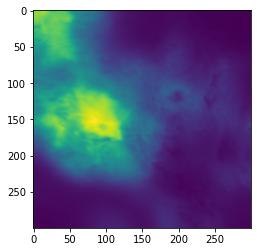

In [297]:
sat_img = next(iter(test_loader))
out_pred_raw_1 = model(sat_img[0])
out_image_1 = torch.nn.functional.sigmoid(out_pred_raw_1)
out_probs_1 = out_image_1[0,0,:,:].detach().numpy()
plt.imshow(out_probs_1)

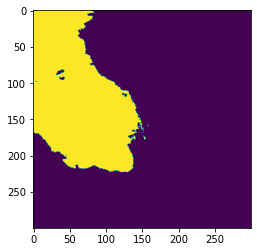

In [298]:
out_map_1 = (out_image_1 > 0.3).int()[0,0,:,:].detach().numpy()
plt.imshow(out_map_1)

(-0.5, 299.5, 299.5, -0.5)

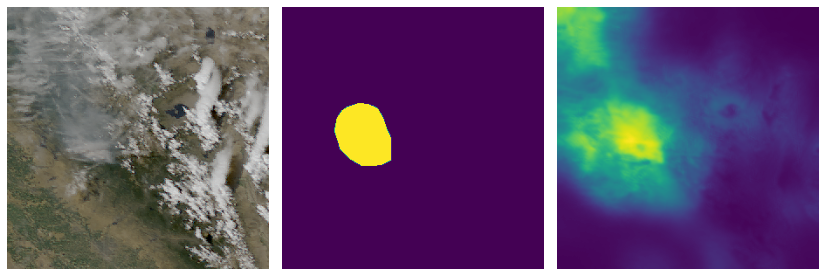

In [321]:
f, ax = plt.subplots(1, 3, figsize=(12, 5))
f.tight_layout()
f.subplots_adjust(hspace=.05, wspace=.05)
ax = ax.ravel()

# plot the true_color and second channel image
ax[0].imshow(sat_img[0][0,0:3,:,:].cpu().numpy().transpose((1,2,0)))
ax[0].axis('off')
ax[1].imshow(map_image)
ax[1].axis('off')
ax[2].imshow(out_probs_1)
ax[2].axis('off')
# ax[3].imshow(out_map_1)
# ax[3].axis('off')

In [279]:
out_pred_raw = model(sat_image.unsqueeze(0))

In [280]:
out_image = torch.nn.functional.sigmoid(out_pred_raw)

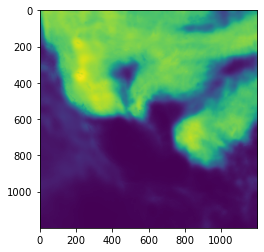

In [281]:
out_probs = out_image[0,0,:,:].detach().numpy()
plt.imshow(out_probs)

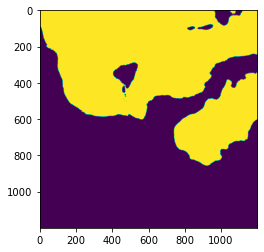

In [282]:
out_map = (out_image > 0.3).int()[0,0,:,:].detach().numpy()
plt.imshow(out_map)

In [280]:
## save mask and pred images
im = Image.fromarray(out_probs)
im.save('../data/img/out_img/pred_probs_G16_doy217_s201808051730_e201808051741_with_merra.tiff')

In [281]:
im = Image.fromarray((out_map*255).astype(np.uint8))
im.save('../data/img/out_img/pred_map_G16_doy217_s201808051730_e201808051741_with_merra.png')

## Read in `.png` and crop to CA/NV

In [5]:
import rasterio

In [304]:
test_src = rasterio.open('../data/img/test_img/true_color_G16_doy217_s201808051730_e201808051741.tiff')
src = rasterio.open('../data/img/true_color_G16_doy250_s201809071902_e201809071904.png')

In [373]:
from shapely.geometry import box
from rasterio.mask import mask
import geopandas as gpd
from fiona.crs import from_epsg

In [415]:
bands = [1,2,3]
in_west, in_south, in_east, in_north = (-124.5, 24.4, -66.6, 49.3)
out_west, out_south, out_east, out_north = (-124.48200299999999, 32.528832, -114.131211, 42.009502999999995)

transform = rasterio.transform.from_bounds(in_west, in_south, in_east, in_north, width=4800,height=2700)
window = rasterio.windows.from_bounds(out_west, out_south, out_east, out_north, transform)

out_width = 1200
out_height = 1200

with rasterio.open('../data/img/trial_img.png', mode='r+') as src:

    with rasterio.open('../data/img/trial_img_cropped.png', 'w', driver='PNG',
                       width=out_width, height=out_height,
                       count=3, dtype=data.dtype, crs=crs) as dst:
        dst.write(src.read(bands, window=window), indexes=bands)

## Test dataloader

In [204]:
import numpy as np
import glob
import os
from PIL import Image, ImageFile
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torch

# some images dont load properly, but dont seem to have problems
# doing this to get around issue
ImageFile.LOAD_TRUNCATED_IMAGES = True

class WildfireSmokePredictDataset(Dataset):
    """
    Wildfire Smoke Dataset class for PyTorch to read in wildfire smoke segmentation data
    """
    def __init__(self, files_dir, bands=['true_color','C07','C11'], transform=transforms.ToTensor()):
        """
        Args:
            files_dir (string): Path to image files
            bands (list): list of bands to use
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dir = files_dir
        self.bands = bands
        self.transform = transform
        self.img_dirname, self.img_slugs = self._find_imgs(files_dir)


    def __len__(self):
        return len(self.img_slugs)

    def __getitem__(self, idx):
        
        # read in images
        temp_img_list = []
        for band in self.bands:
                
            if band == 'merra2':
                try:

                    # get merra filename params from true color slug
                    fname_params = h.get_true_color_filename_split_dict(self.img_slugs[idx])
                    #true_color_fn = file_str.split('/')[-1]
                    #start_end_slug = true_color_fn.split('_')[4] +'_'+ true_color_fn.split('_')[5].split('.')[0]

                    temp_img_name = f"{self.img_dirname}/{band}_{fname_params['year']}{fname_params['month']}{fname_params['day']}.tiff"

                    # clip values to between 0 and 5 for merra2
                    merra2_img = np.clip(np.array(Image.open(temp_img_name)), a_min=0, a_max=5)

                except ValueError:
                    print(f"error reading: {temp_img_name}")
                
            else:
                
                # get image filename from true color slug
                temp_img_name = f"{self.img_dirname}/{band}_{'_'.join(self.img_slugs[idx].split('/')[-1].split('_')[2:])}"
                temp_img = np.array(Image.open(temp_img_name))

                # add image to dict
                if band == 'true_color':
                    temp_img_list.append(temp_img[:,:,0:3])

                elif band in ['C07', 'C11']:

                    # repeated values for the other bands...
                    temp_img_list.append(temp_img[:,:,0])
                
            
        # create numpy image array with all channels
        sat_image = np.dstack(temp_img_list)     
        
        if self.transform:
            sat_image = self.transform(sat_image)
            
            # transfrom merra2 separately cause of different scales
            if 'merra2' in self.bands:
                
                merra2_img = transforms.functional.normalize(torch.as_tensor(merra2_img).unsqueeze(0), mean=[0.13749852776527405], std=[0.042889975011348724])
                
                # concatenate merra2 onto sat image
                sat_image = torch.cat((sat_image, merra2_img), dim=0)

        return sat_image, self.img_slugs[idx]
    
    def _find_imgs(self, files_dir):

        ## gather image filenames for true_color (which each has corresponding channel/ masks)
        imgs = glob.glob(f'{files_dir}/true_color*')
        img_dirname = os.path.dirname(imgs[0])
        img_slugs = sorted([os.path.basename(file_str) for file_str in imgs])

        return img_dirname, img_slugs

In [212]:
test_dataset = WildfireSmokePredictDataset("../data/img/test_img/", 
                            bands=['true_color','C07','C11'], 
                            transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=3, num_workers=0, shuffle=False)

In [213]:
it = iter(test_loader)
blah, fname = next(it)

In [214]:
blah[2,:,:,:].unsqueeze(0).shape

torch.Size([1, 5, 1200, 1200])

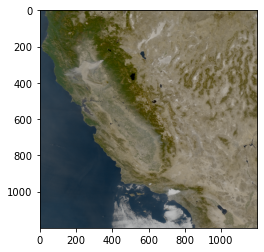

In [215]:
plt.imshow(blah[2,0:3,:,:].cpu().numpy().transpose((1,2,0)))

In [216]:
out_preds_raw_1 = model(blah[2,:,:,:].unsqueeze(0))
out_probs = torch.nn.functional.sigmoid(out_preds_raw_1)
out_maps = (out_probs > 0.3).int().detach().numpy()

In [242]:
out_map_store_dict = {'out_map':[], 'fname':[]}
import pickle

In [322]:
with open('../data/smoke_plumes/predict_trial_6.pickle', 'rb') as f:
    out_map_store_dict = pickle.load(f)

EOFError: Ran out of input

In [264]:
out_map_store_dict['fname'][2]

('true_color_G16_doy248_s201909052201_e201909052203.png',)

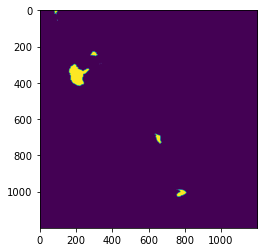

In [223]:
plt.imshow(out_maps[0,0,:,:])

In [15]:
out_preds_raw_1 = model(blah)
out_preds_raw_2 = model(blah_1)
out_preds_raw_3 = model(blah_2)

In [16]:
out_preds_raw = torch.cat((out_preds_raw_1, out_preds_raw_2, out_preds_raw_3), dim=0)

In [17]:
out_probs = torch.nn.functional.sigmoid(out_preds_raw)

# threshold and turn into mask
out_maps = (out_probs > 0.3).int().detach().numpy()

In [114]:
from utils import data_prep as dp

In [117]:
zing = raster_to_poly(out_maps, fname)
#zing = gpd.GeoDataFrame(zing, crs="EPSG:4326")

In [115]:
# format plumes by creating intermediate features
#zing = dp.format_plume_data(zing)

In [13]:
what = out_maps[2,0,:,:]

NameError: name 'out_maps' is not defined

In [ ]:
shapes = rasterio.features.shapes(what)
shapes_list = list(shapes)

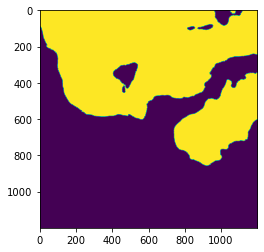

In [606]:
plt.imshow(rasterio.features.sieve(what, 100))

In [615]:
out_west, out_south, out_east, out_north = (-124.48200299999999, 32.528832, -114.131211, 42.009502999999995)
transform = rasterio.transform.from_bounds(out_west, out_south, out_east, out_north, width=1200,height=1200)

In [629]:
shapes = rasterio.features.shapes(rasterio.features.sieve(what, 100), transform=transform)
shapes_list = list(shapes)

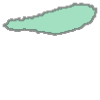

In [630]:
shape(shapes_list[3][0])

In [11]:
## read in plume data
test_predict_plumes_df = gpd.read_file("../data/smoke_plumes/predict_test.geojson")

In [12]:
test_predict_plumes_df

,Start,End,year,month,day,start_doy,end_doy,start_time,end_time,view,doy,time,conus_time,geometry
0,2018217 1730,2018217 1741,2018,08,05,217,217,1730,1741,F,217,1741,1742,"POLYGON ((-115.42506 42.00950, -115.42506 42.0..."
1,2018217 1730,2018217 1741,2018,08,05,217,217,1730,1741,F,217,1741,1742,"POLYGON ((-124.48200 42.00950, -124.48200 41.2..."
2,2018217 1730,2018217 1741,2018,08,05,217,217,1730,1741,F,217,1741,1742,"POLYGON ((-114.20022 39.29961, -114.20022 39.2..."
3,2018259 1602,2018259 1604,2018,09,16,259,259,1602,1604,C,259,1604,1607,"POLYGON ((-116.96043 42.00950, -116.96043 41.9..."
4,2018259 1602,2018259 1604,2018,09,16,259,259,1602,1604,C,259,1604,1607,"POLYGON ((-122.26521 41.26685, -122.26521 41.2..."
5,2018312 1800,2018312 1811,2018,11,08,312,312,1800,1811,F,312,1811,1812,"POLYGON ((-123.80920 42.00950, -123.80920 41.9..."
6,2018312 1800,2018312 1811,2018,11,08,312,312,1800,1811,F,312,1811,1812,"POLYGON ((-121.92881 40.21608, -121.92881 40.2..."
7,2018312 1800,2018312 1811,2018,11,08,312,312,1800,1811,F,312,1811,1812,"POLYGON ((-122.86900 39.66304, -122.86900 39.6..."
8,2018312 1800,2018312 1811,2018,11,08,312,312,1800,1811,F,312,1811,1812,"POLYGON ((-119.01333 36.62922, -119.01333 36.6..."
9,2018312 1800,2018312 1811,2018,11,08,312,312,1800,1811,F,312,1811,1812,"POLYGON ((-117.85750 34.21165, -117.85750 34.2..."


In [131]:
criterion = nn.BCELoss()
criterion1 = nn.BCELoss(reduction='none')

In [129]:
out_raw = model(blah['sat_img'])
out = torch.nn.functional.sigmoid(out_raw)

In [130]:
criterion(out, blah['map_img'])

tensor(0.2497, grad_fn=<BinaryCrossEntropyBackward>)

In [132]:
zing = criterion1(out, blah['map_img'])

In [144]:
N, C, H, W = zing.shape
zing.sum(dim=(2,3), keepdim=True).div(H*W).sum().div(3)

tensor(0.2497, grad_fn=<DivBackward0>)